## Imports

In [1]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from khan_helpers import Experiment
from khan_helpers.constants import (
    CV_PARAMS,
    FIG_DIR,
    LDA_PARAMS,
    MODELS_DIR,
    TRAJS_DIR,
    RAW_DIR, 
    LECTURE_WSIZE
)
from khan_helpers.functions import (
    _ts_to_sec,
    interp_lecture,
    format_text, 
    multicol_display,
    parse_windows,
    show_source
)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Inspect some things defined in `khan_helpers`

In [2]:
show_source(Experiment)

In [3]:
show_source(format_text)

In [4]:
show_source(parse_windows)

In [5]:
show_source(_ts_to_sec)

In [6]:
show_source(interp_lecture)

In [7]:
show_source(multicol_display)

In [8]:
show_source(show_source)

In [9]:
def get_top_words(cv, lda, n_words=10):
    topic_words = {}
    vocab = cv.get_feature_names()
    for topic, component in enumerate(lda.components_):
        word_ix = np.argsort(component)[::-1][:n_words]
        topic_words[topic] = [vocab[i] for i in word_ix]
    return topic_words

## Inspect some raw data we're working with

In [10]:
exp = Experiment()
multicol_display(exp.forces_transcript[:309], exp.bos_transcript[:305], 
                 ncols=2, 
                 col_headers=['The Four Forces of Nature', 'The Birth of Stars'],
                 header_css={
                     'font-size': '14px', 
                     'text-align': 'center'
                 }, 
                 cell_css={
                     'text-align': 'left', 
                     'font-size': '12px', 
                     'background-color': 'white', 
                     'padding-left': '10%'
                 })

0:00what I want to do in this video is give00:01a very high-level overview of the four00:04fundamental forces four fundamental00:07forces of the universe and I'm going to00:09start with gravity I'm going to start00:12with gravity and it might surprise some00:15of you that gravity is actually the,00:00let's imagine we have a huge cloud of00:02hydrogen atoms floating in space Hugh00:05and I say huge cloud huge both in00:07distance and in mass if you were to00:09combine all of the hydrogen atoms it00:11would just be this really really massive00:14thing so you have this huge cloud well
,


In [11]:
exp.questions.head()

,lecture,question,A,B,C,D
index,,,,,,
1,1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,1,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,1,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,1,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,1,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...


## Show some parameters

In [12]:
# lecture transcript sliding window length
print(f'window length:\n\t{LECTURE_WSIZE} lines')
multicol_display(
    CV_PARAMS, LDA_PARAMS, 
    col_headers=("CountVectorizer params", "LatentDirichletAllocation params"), 
    ncols=2,
    header_css={'text-align': 'center'},
    cell_css={'text-align': 'center'}
)

window length:
	20 lines


"strip_accents: unicodestop_words: i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mustn't, needn, needn't, shan, shan't, shouldn, shouldn't, wasn, wasn't, weren, weren't, won, won't, wouldn, wouldn't, even, i'll, i'm, let, let's, really, they'd, they're, they've, they'll, that's",n_components: 10learning_method: batchrandom_state: 0
,


## preprocess and reformat text

In [13]:
# get sliding windows & timestamps from lecture transcripts
ff_windows, ff_timestamps = parse_windows(exp.forces_transcript, LECTURE_WSIZE)
bos_windows, bos_timestamps = parse_windows(exp.bos_transcript, LECTURE_WSIZE)

# remove punctuation, stop-words, digits, etc.
ff_windows = format_text(ff_windows)
bos_windows = format_text(bos_windows)

# format quiz questions and correct answers
grouped_qdf = exp.questions.groupby('lecture')
gen_qs, ff_qs, bos_qs = grouped_qdf['question'].apply(format_text)
all_qs = ff_qs + bos_qs + gen_qs
# gen_correct, ff_correct, bos_correct = grouped_qdf['A'].apply(format_text)
# all_ans_correct = ff_correct + bos_correct + gen_correct

# format all answers
all_ans = exp.questions.loc[:, 'A':].apply(format_text, axis=1).to_dict()

## Model lectures and quiz questions

In [14]:
# create corpus
corpus = (
    ff_windows 
    + bos_windows 
    + all_qs 
    + np.ravel(list(all_ans.values())).tolist()
)

# fit CountVectorizer model, vectorize corpus for fitting topic model
tf_vectorizer = CountVectorizer(**CV_PARAMS).fit(corpus)
corpus_tf = tf_vectorizer.transform(corpus)
# vectorize lecture windows
ff_lec_tf = tf_vectorizer.transform(ff_windows)
bos_lec_tf = tf_vectorizer.transform(bos_windows)
# vectorize questions
ff_qs_tf = tf_vectorizer.transform(ff_qs)
bos_qs_tf = tf_vectorizer.transform(bos_qs)
gen_qs_tf = tf_vectorizer.transform(gen_qs)

# fit LatentDirichletAllocation model
lda = LatentDirichletAllocation(**LDA_PARAMS).fit(corpus_tf)
# transform lecture windows
ff_traj = lda.transform(ff_lec_tf)
bos_traj = lda.transform(bos_lec_tf)
# transform questions
ff_qs_vecs = lda.transform(ff_qs_tf)
bos_qs_vecs = lda.transform(bos_qs_tf)
gen_qs_vecs = lda.transform(gen_qs_tf)

# interpolate lecture trajectories to 1 sample per second
ff_traj = interp_lecture(ff_traj, ff_timestamps)
bos_traj = interp_lecture(bos_traj, bos_timestamps)

## Concat question vectors, transform answers

In [15]:
qs_concat = np.concatenate((ff_qs_vecs, bos_qs_vecs, gen_qs_vecs))
all_questions = np.empty((39, 10), dtype=np.float64)
all_answers = np.empty((39, 4, 10), dtype=np.float64)
for ix, q_vec in enumerate(qs_concat):
    all_questions[ix] = q_vec
    all_answers[ix] = lda.transform(tf_vectorizer.transform(all_ans[ix + 1]))

In [16]:
exp.forces_traj = ff_traj
exp.bos_traj = bos_traj
exp.question_vectors = all_questions
exp.answer_vectors = all_answers

/opt/conda/lib/python3.7/site-packages/hypertools/plot/plot.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


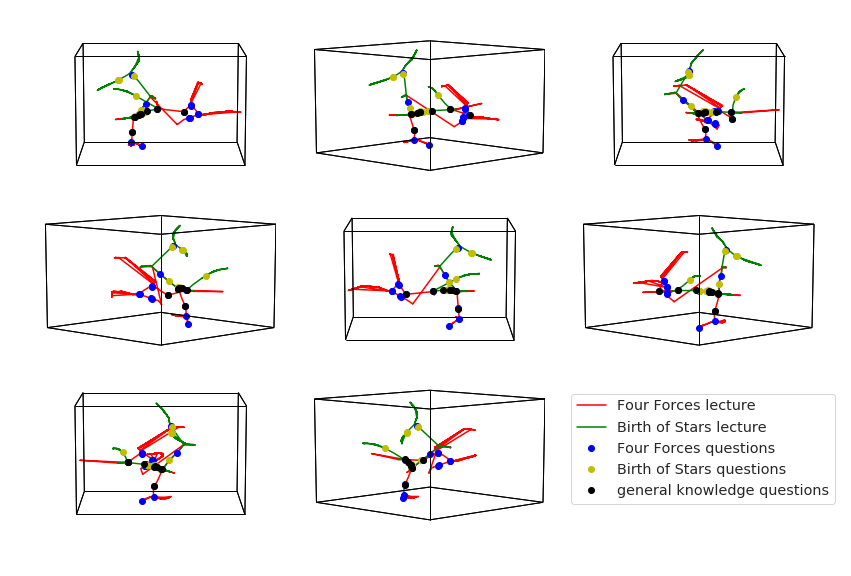

In [17]:
fig, axarr = plt.subplots(3, 3, subplot_kw={'projection': '3d'}, gridspec_kw={'wspace': -.1, 'hspace': -.1})
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for ax, azim in zip(axarr, range(0, 360, 45)):
    ax = exp.plot(lectures=['forces', 'bos'], 
                  questions=['forces', 'bos', 'general'], 
                  fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                  reduce='UMAP', 
                  azim=azim, 
                  show=False, 
                  ax=ax)
    
axarr[-1].axis('off')
fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
            'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
           loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
# fig.savefig(FIG_DIR.joinpath('lectures-questions-3d-9.pdf'), bbox_inches='tight')
fig

/opt/conda/lib/python3.7/site-packages/hypertools/plot/plot.py:414: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


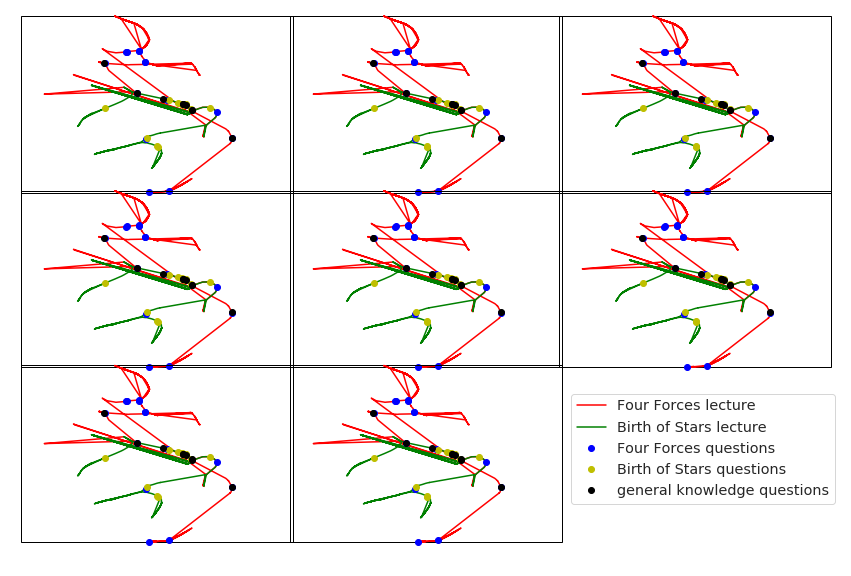

In [18]:
fig, axarr = plt.subplots(3, 3, gridspec_kw={'wspace': -.1, 'hspace': -.1})
fig.set_size_inches(15, 10)
axarr = axarr.flatten()
np.random.seed(0)
for ax, azim in zip(axarr, range(0, 360, 45)):
    ax = exp.plot(lectures=['forces', 'bos'], 
                  questions=['forces', 'bos', 'general'], 
                  fmt=['r-', 'g-', 'bo', 'yo', 'ko'], 
                  reduce={'model': 'UMAP', 'params': {'random_state': 0}}, 
                  ndims=2,
                  azim=azim, 
                  show=False, 
                  ax=ax)
    
axarr[-1].axis('off')
fig.legend(['Four Forces lecture', 'Birth of Stars lecture', 
            'Four Forces questions', 'Birth of Stars questions', 'general knowledge questions'],
           loc='lower right', bbox_to_anchor=(.78, .09), fontsize='x-large')
# fig.savefig(FIG_DIR.joinpath('lectures-questions-3d-9.pdf'), bbox_inches='tight')
fig

In [19]:
topic_words = get_top_words(tf_vectorizer, lda)
for topic, words in topic_words.items():
    print(f'topic {topic + 1}:\n\t{", ".join(words)}')

topic 1:
	force, energy, go, keep, one, pressure, called, actually, mass, little
topic 2:
	weak, interaction, proton, one, neutrons, cesium, electron, extra, going, get
topic 3:
	force, charge, strong, huge, gravity, large, see, mass, distances, electromagnetic
topic 4:
	atoms, denser, hydrogen, going, slowly, huge, cloud, center, mass, would
topic 5:
	force, gravity, times, weak, huge, distances, scales, strength, interaction, relative
topic 6:
	hydrogen, helium, one, atomic, two, mass, deuterium, four, fused, energy
topic 7:
	fusion, get, threshold, main, mass, pressure, theres, actually, sequence, core
topic 8:
	force, see, scale, theres, like, coulomb, charges, things, attraction, way
topic 9:
	two, enough, protons, actually, force, nucleus, ignition, strong, coulomb, first
topic 10:
	forces, around, hydrogen, actually, atom, much, four, nucleus, scale, gravity


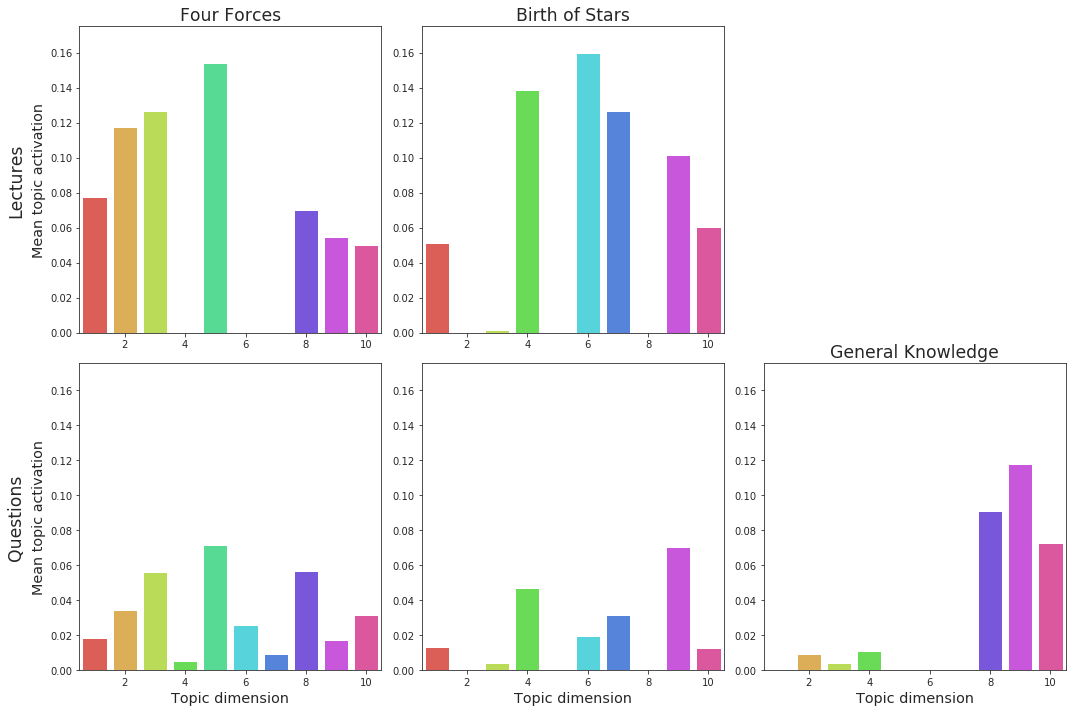

In [20]:
sns.set_style('ticks')
fig, axarr = plt.subplots(2, 3)
fig.set_size_inches(15, 10)
axarr = axarr.flatten()

for i, traj in enumerate([ff_traj, bos_traj, None, ff_qs_vecs, bos_qs_vecs, gen_qs_vecs]):
    ax = axarr[i]
    if traj is None:
        ax.axis('off')
        continue
        
    topic_vars = np.var(traj, axis=0)
    bars = ax.bar(x=list(range(1, 11)), height=topic_vars, color=sns.color_palette('hls', 10))
    ax.set_ylim(0, .175)
    ax.set_xlim(.5, 10.5)
    ax.set_xticks(list(range(2, 11, 2)))
    
    if i == 0:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.set_title('Four Forces', fontsize='xx-large')
        ax.annotate('Lectures', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 1:
        ax.set_title('Birth of Stars', fontsize='xx-large')
    elif i == 3:
        ax.set_ylabel('Mean topic activation', fontsize='x-large')
        ax.annotate('Questions', xy=(-.5, .5), xycoords=ax.yaxis.label, 
                    size='xx-large', rotation=90, ha='right', va='center')
    elif i == 5:
        ax.set_title('General Knowledge', fontsize='xx-large')
        
    if i > 2:
        ax.set_xlabel('Topic dimension', fontsize='x-large')
        

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('topics-vars.pdf'), bbox_inches='tight')
plt.show()

## Save trajectories and fit models

In [21]:
# np.save(TRAJS_DIR.joinpath('forces_lecture'), ff_traj)
# np.save(TRAJS_DIR.joinpath('bos_lecture'), bos_traj)
# np.save(TRAJS_DIR.joinpath('all_questions'), all_questions)
# np.save(TRAJS_DIR.joinpath('all_answers'), all_answers)
# np.save(RAW_DIR.joinpath('forces_windows'), ff_windows)
# np.save(RAW_DIR.joinpath('bos_windows'), bos_windows)
# np.save(MODELS_DIR.joinpath('fit_CV'), tf_vectorizer)
# np.save(MODELS_DIR.joinpath('fit_LDA'), lda)